In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install openpyxl


In [28]:
import pandas as pd
df=pd.read_excel("data.xlsx")

In [29]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [30]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Rows with missing customerIDS are dropped to preserve customer level analysis report

In [6]:
print("Before dropping:" , df.shape)
original_rows=df.shape[0]
# Dropping missing customerID rows 
df=df.dropna(subset=['CustomerID'])
new_rows=df.shape[0]
print("AFTER DROPPING:", df.shape)

Before dropping: (541909, 8)
AFTER DROPPING: (406829, 8)


In [7]:
# Data loss percentage
loss_percent=100*(original_rows-new_rows)/original_rows
print(f"Data Loss after dropping: {loss_percent:.2f}%")

Data Loss after dropping: 24.93%


In [8]:
# Removing Cancelled Orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [9]:
# Create the total price = Quantity*UnitPrice
df['TotalPrice']=df['Quantity']*df['UnitPrice']

In [10]:
# Keeping Only Postive Quantity and Prices
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]

In [11]:
import datetime as dt
# adds exactly one day to that latest date
snapshot_date=df['InvoiceDate'].max()  + dt.timedelta(days=1)

# Find last purchase date for each customer
recency_df=df.groupby('CustomerID')["InvoiceDate"].max()
recency_df=(snapshot_date - recency_df).dt.days

# Convert results into dataframe
recency_df=recency_df.to_frame("Recency")

In [12]:
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().to_frame('Frequency')

In [13]:
monetary_df = df.groupby('CustomerID')['TotalPrice'].sum().to_frame('Monetary')

In [14]:
rfm_df=recency_df.join(frequency_df).join(monetary_df).reset_index()
print(rfm_df.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


EDA

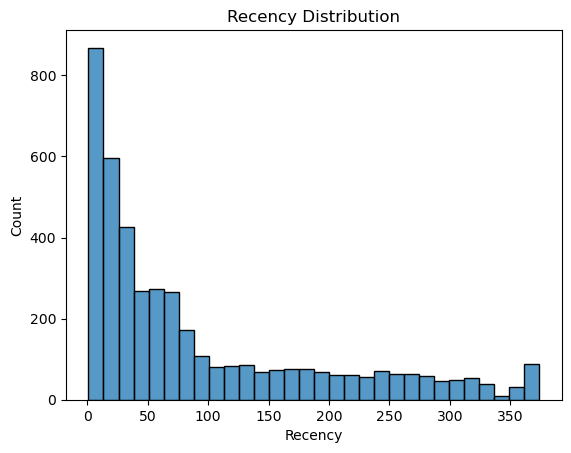

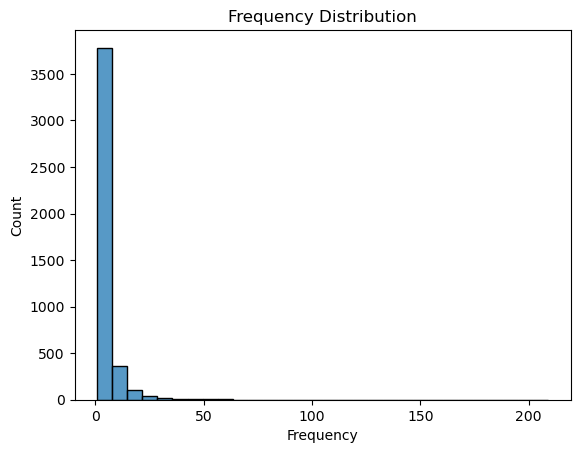

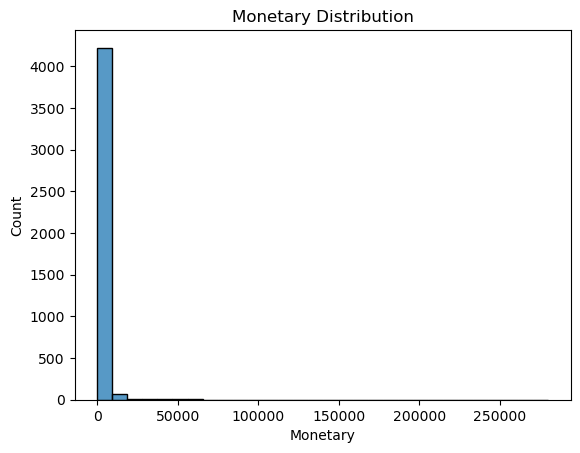

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm_df['Recency'], bins=30)
plt.title('Recency Distribution')
plt.show()

sns.histplot(rfm_df['Frequency'], bins=30)
plt.title('Frequency Distribution')
plt.show()

sns.histplot(rfm_df['Monetary'], bins=30)
plt.title('Monetary Distribution')
plt.show()


In [16]:
# Top 10 products Products
df['Description'].value_counts().head(10)

Description
WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1723
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1396
LUNCH BAG RED RETROSPOT               1316
SET OF 3 CAKE TINS PANTRY DESIGN      1159
LUNCH BAG  BLACK SKULL.               1105
POSTAGE                               1099
PACK OF 72 RETROSPOT CAKE CASES       1068
Name: count, dtype: int64

In [17]:
# Top Customers sorted by total price
df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
12415.0    124914.53
14156.0    117379.63
17511.0     91062.38
16029.0     81024.84
12346.0     77183.60
Name: TotalPrice, dtype: float64

In [18]:
# Country distribuion
df['Country'].value_counts()

Country
United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [19]:
df.duplicated().sum()


5192

In [20]:
df = df.drop_duplicates()


<Axes: xlabel='InvoiceMonth'>

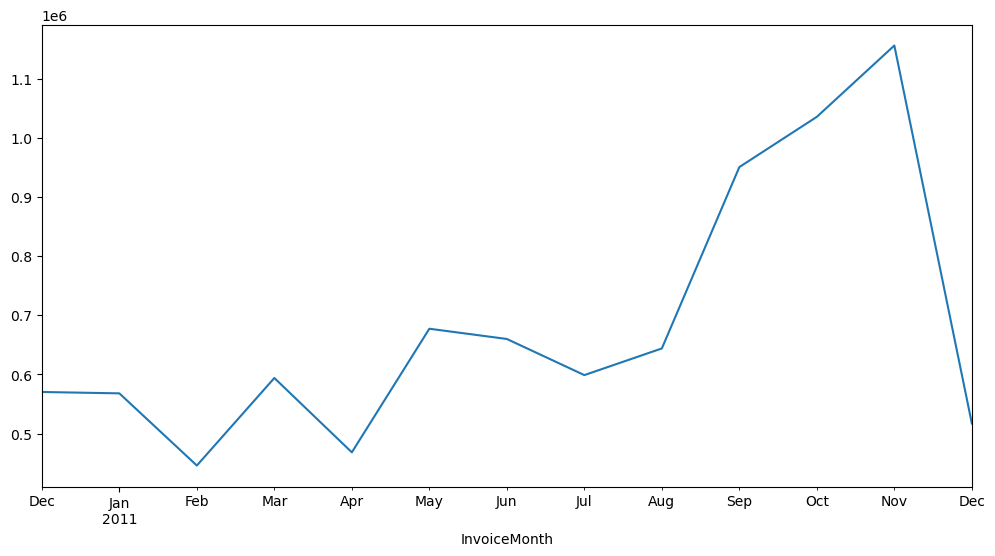

In [21]:
# Monthly sales trend
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()

monthly_sales.plot(kind='line', figsize=(12,6))


<Axes: xlabel='Quantity', ylabel='TotalPrice'>

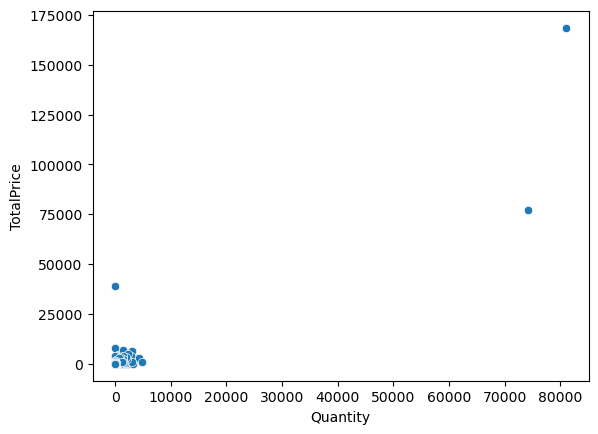

In [22]:
sns.scatterplot(x='Quantity', y='TotalPrice', data=df)


Most users are buying small quantities, less spending.Remaining are outliers or fake data.

Customer Segmentation

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_df[['Recency','Frequency','Monetary']])

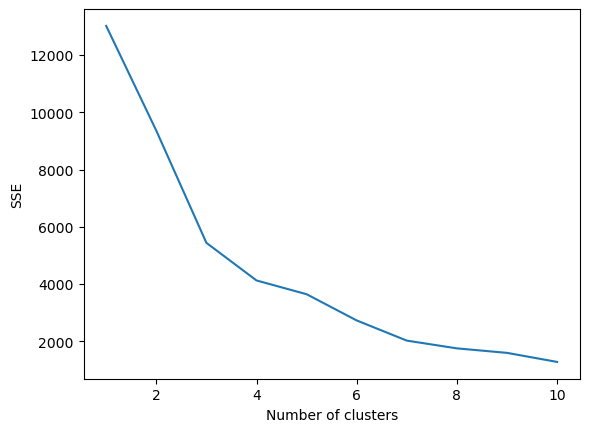

In [24]:
# Finding optimal number of clusters using elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse={}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

Assuming k=4 because significant drop in SSE at that point

In [25]:
# Apply Kmeans
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(rfm_scaled)
rfm_df['Cluster'] = kmeans.labels_
print(rfm_df.head())

   CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      326          1  77183.60        2
1     12347.0        2          7   4310.00        0
2     12348.0       75          4   1797.24        0
3     12349.0       19          1   1757.55        0
4     12350.0      310          1    334.40        1


<Axes: xlabel='Recency', ylabel='Monetary'>

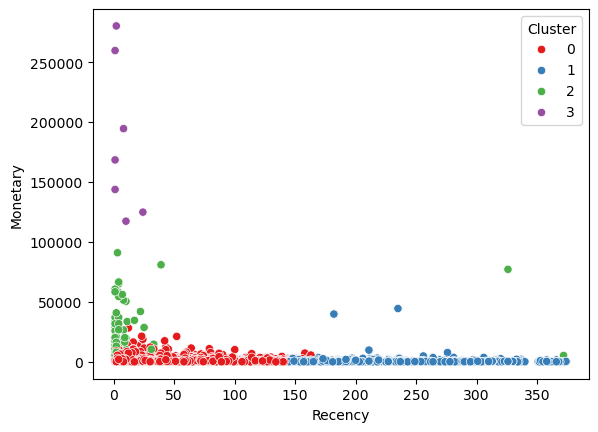

In [26]:
# Visualize clusters
sns.scatterplot(x="Recency",y="Monetary",hue="Cluster", data=rfm_df, palette="Set1")

In [27]:
# Example new customer data
new_customer = pd.DataFrame({
    'Recency': [30], 
    'Frequency': [10], 
    'Monetary': [500]
})

# Scale the new customer's RFM values
new_customer_scaled = scaler.transform(new_customer)

# Predict the cluster
predicted_cluster = kmeans.predict(new_customer_scaled)

print("Predicted Cluster:", predicted_cluster[0])


Predicted Cluster: 0
